# Банковский маркетинг

## Описание задачи

В данном датасете содержатся данные, собранные на основе телефонных звонков, полученные от одного из банковских учреждений. [Источник](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing)  
Имеется следующая информация:

1. **Age:** Возраст клиента
2. **Job:** Вид рабочей деятельности
3. **Marital:** Семейное положение
4. **Education:** Образование
5. **Default:** Наличие кредита
6. **Balance:** Текущий баланс
7. **Housing:** Наличие жилищного кредита
8. **Loan:** Наличие личного заёма
9. **Contact:** Вид связи, который использовался для связи с клиентом
10. **Month:** День последнего контакта
11. **Day of week:** Месяц последнего контакта
12. **Duration:** Продолжительость последнего контакта
13. **Campaign:** Количество контактов с клиентом во время текущей кампании
14. **Pdays:** Количество дней, прошедших после того, как с клиентом последний раз связались в рамках предыдущей кампании
15. **Previous:** Количество контактов с клиентом, выполненных до текущей кампании
16. **Poutcome:** Результат предыдущей маркетинговой кампании

На основе данных, представленных в данном датасете, необходимо предсказать, подпишется ли клиент на срочный депозит в рамках текущей маркетинговой кампании.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import ensemble
%matplotlib inline

Прочитаем датасет и выведем количество признаков и исследуемых объектов:

In [22]:
data = pd.read_csv("dataset.csv")
data.shape

(45211, 17)

Данные представлены следующим образом:

In [23]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Заметим, что признаки **default**, **housing** и **loan** принимают только значения *yes* и *no*, то есть являются бинарными. Кроме того, предсказываемое значение **y** также является бинарным. Зададим упомянутым столбцам тип **bool**:

In [24]:
data["default"] = data["default"] == "yes"
data["housing"] = data["housing"] == "yes"
data["loan"] = data["loan"] == "yes"
data["y"] = data["y"] == "yes"

Далее отметим, что **job**, **marital**, **education**, **contact**, **month**, **poutcome** являются категориальными признаками. Зададим это явно:

In [25]:
data["job"] = data["job"].astype("category")
data["marital"] = data["marital"].astype("category")
data["education"] = data["education"].astype("category")
data["contact"] = data["contact"].astype("category")
data["month"] = data["month"].astype("category")
data["poutcome"] = data["poutcome"].astype("category")

Остальные признаки являются целочисленными.  

## Визуализация данных и вычисление характеристик

Отобразим информацию о признаках, проклассифицировав их по их типу. Информация о бинарных признаках:

In [26]:
data.describe(include = ["bool"])

,default,housing,loan,y
count,45211,45211,45211,45211
unique,2,2,2,2
top,False,True,False,False
freq,44396,25130,37967,39922


Видно, что признак **housing** встречается достаточно равномерно, тогда как для признаков **loan** и **default** гораздо более частым является значение *false*. Предсказываемое значение **y** также не является сбалансированным: большинство исследуемых объектов отказались от срочного депозита.  
Изобразим соотношение значений бинарных признаков на диаграммах 

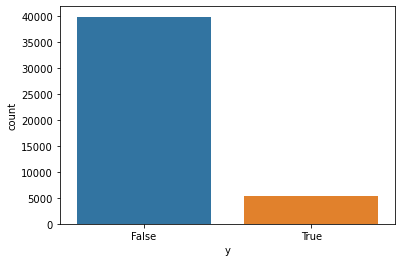

In [27]:
sns.countplot(x = "y", data = data)
pass

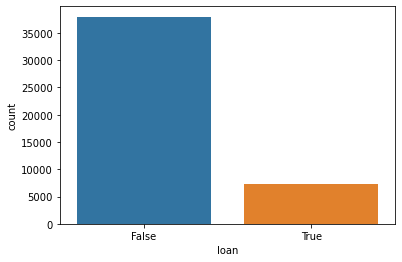

In [28]:
sns.countplot(x = "loan", data = data)
pass

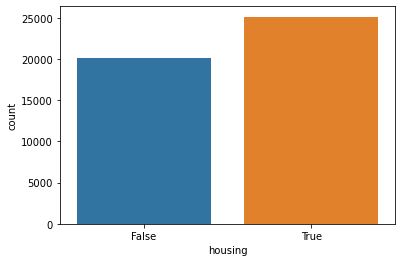

In [29]:
sns.countplot(x = "housing", data = data)
pass

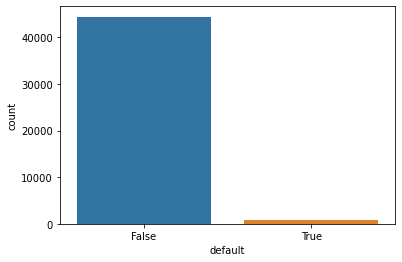

In [30]:
sns.countplot(x = "default", data = data)
pass

Исключим из датасета признак **default** по причине подавляющего доминирования значений *False* над значениями *True*: 

In [31]:
data = data.drop(["default"], axis = 1)

Далее получим информацию о категориальных признаках:

In [32]:
data.describe(include = ["category"])

,job,marital,education,contact,month,poutcome
count,45211,45211,45211,45211,45211,45211
unique,12,3,4,3,12,4
top,blue-collar,married,secondary,cellular,may,unknown
freq,9732,27214,23202,29285,13766,36959


Заметим, что наиболее частым значением признака **poutcome** является *unknown*. Данное значение можем интерпретировать как пропущенное значение. Заменим данное значение в датасете на пустую строку и пересоберем статистику:

In [33]:
data = data.replace("unknown", np.NaN)
data.describe(include = ["category"])

,job,marital,education,contact,month,poutcome
count,44923,45211,43354,32191,45211,8252
unique,11,3,3,2,12,3
top,blue-collar,married,secondary,cellular,may,failure
freq,9732,27214,23202,29285,13766,4901


Заметим, что пропуски значений имеются помимо признака **poutcome** также в **job**, **education** и **contact** 

Отобразим информацию о количественных признаках:

In [34]:
data.describe(include = ["int64"])
numerical_columns = [c for c in data.columns if data[c].dtype.name == 'int64']

Построим корреляционную матрицу для количественных признаков:

In [35]:
correlation = data.corr()
correlation

,age,balance,housing,loan,day,duration,campaign,pdays,previous,y
age,1.000000,0.097783,-0.185513,-0.015655,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
balance,0.097783,1.000000,-0.068768,-0.084350,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
housing,-0.185513,-0.068768,1.000000,0.041323,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.139173
loan,-0.015655,-0.084350,0.041323,1.000000,0.011370,-0.012412,0.009980,-0.022754,-0.011043,-0.068185
day,-0.009120,0.004503,-0.027982,0.011370,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,0.021560,0.005075,-0.012412,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,-0.014578,-0.023599,0.009980,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,0.003435,0.124178,-0.022754,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,0.016674,0.037076,-0.011043,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236
y,0.025155,0.052838,-0.139173,-0.068185,-0.028348,0.394521,-0.073172,0.103621,0.093236,1.000000


Представим в более наглядном виде:

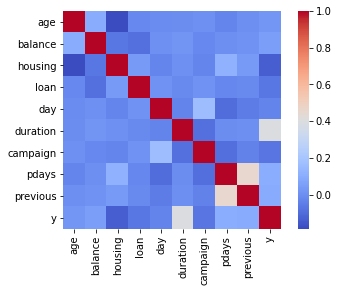

In [36]:
sns.heatmap(correlation, square = True, cmap = "coolwarm")
pass

In [37]:
correlation.where(np.triu(correlation > 0.35, k = 1)).stack().sort_values(ascending = False)

pdays     previous    0.454820
duration  y           0.394521
dtype: float64

На основании данных результатов можно сделать вывод, что признаки слабо коррелированы. Заметная коррелирует пара признаков **pdays** и **previous**, а также **duration** и результат текущей маркетинговой кампании **y**.

Построим диаграммы рассеивания для признаков:

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
No handles with labels found to put in legend.


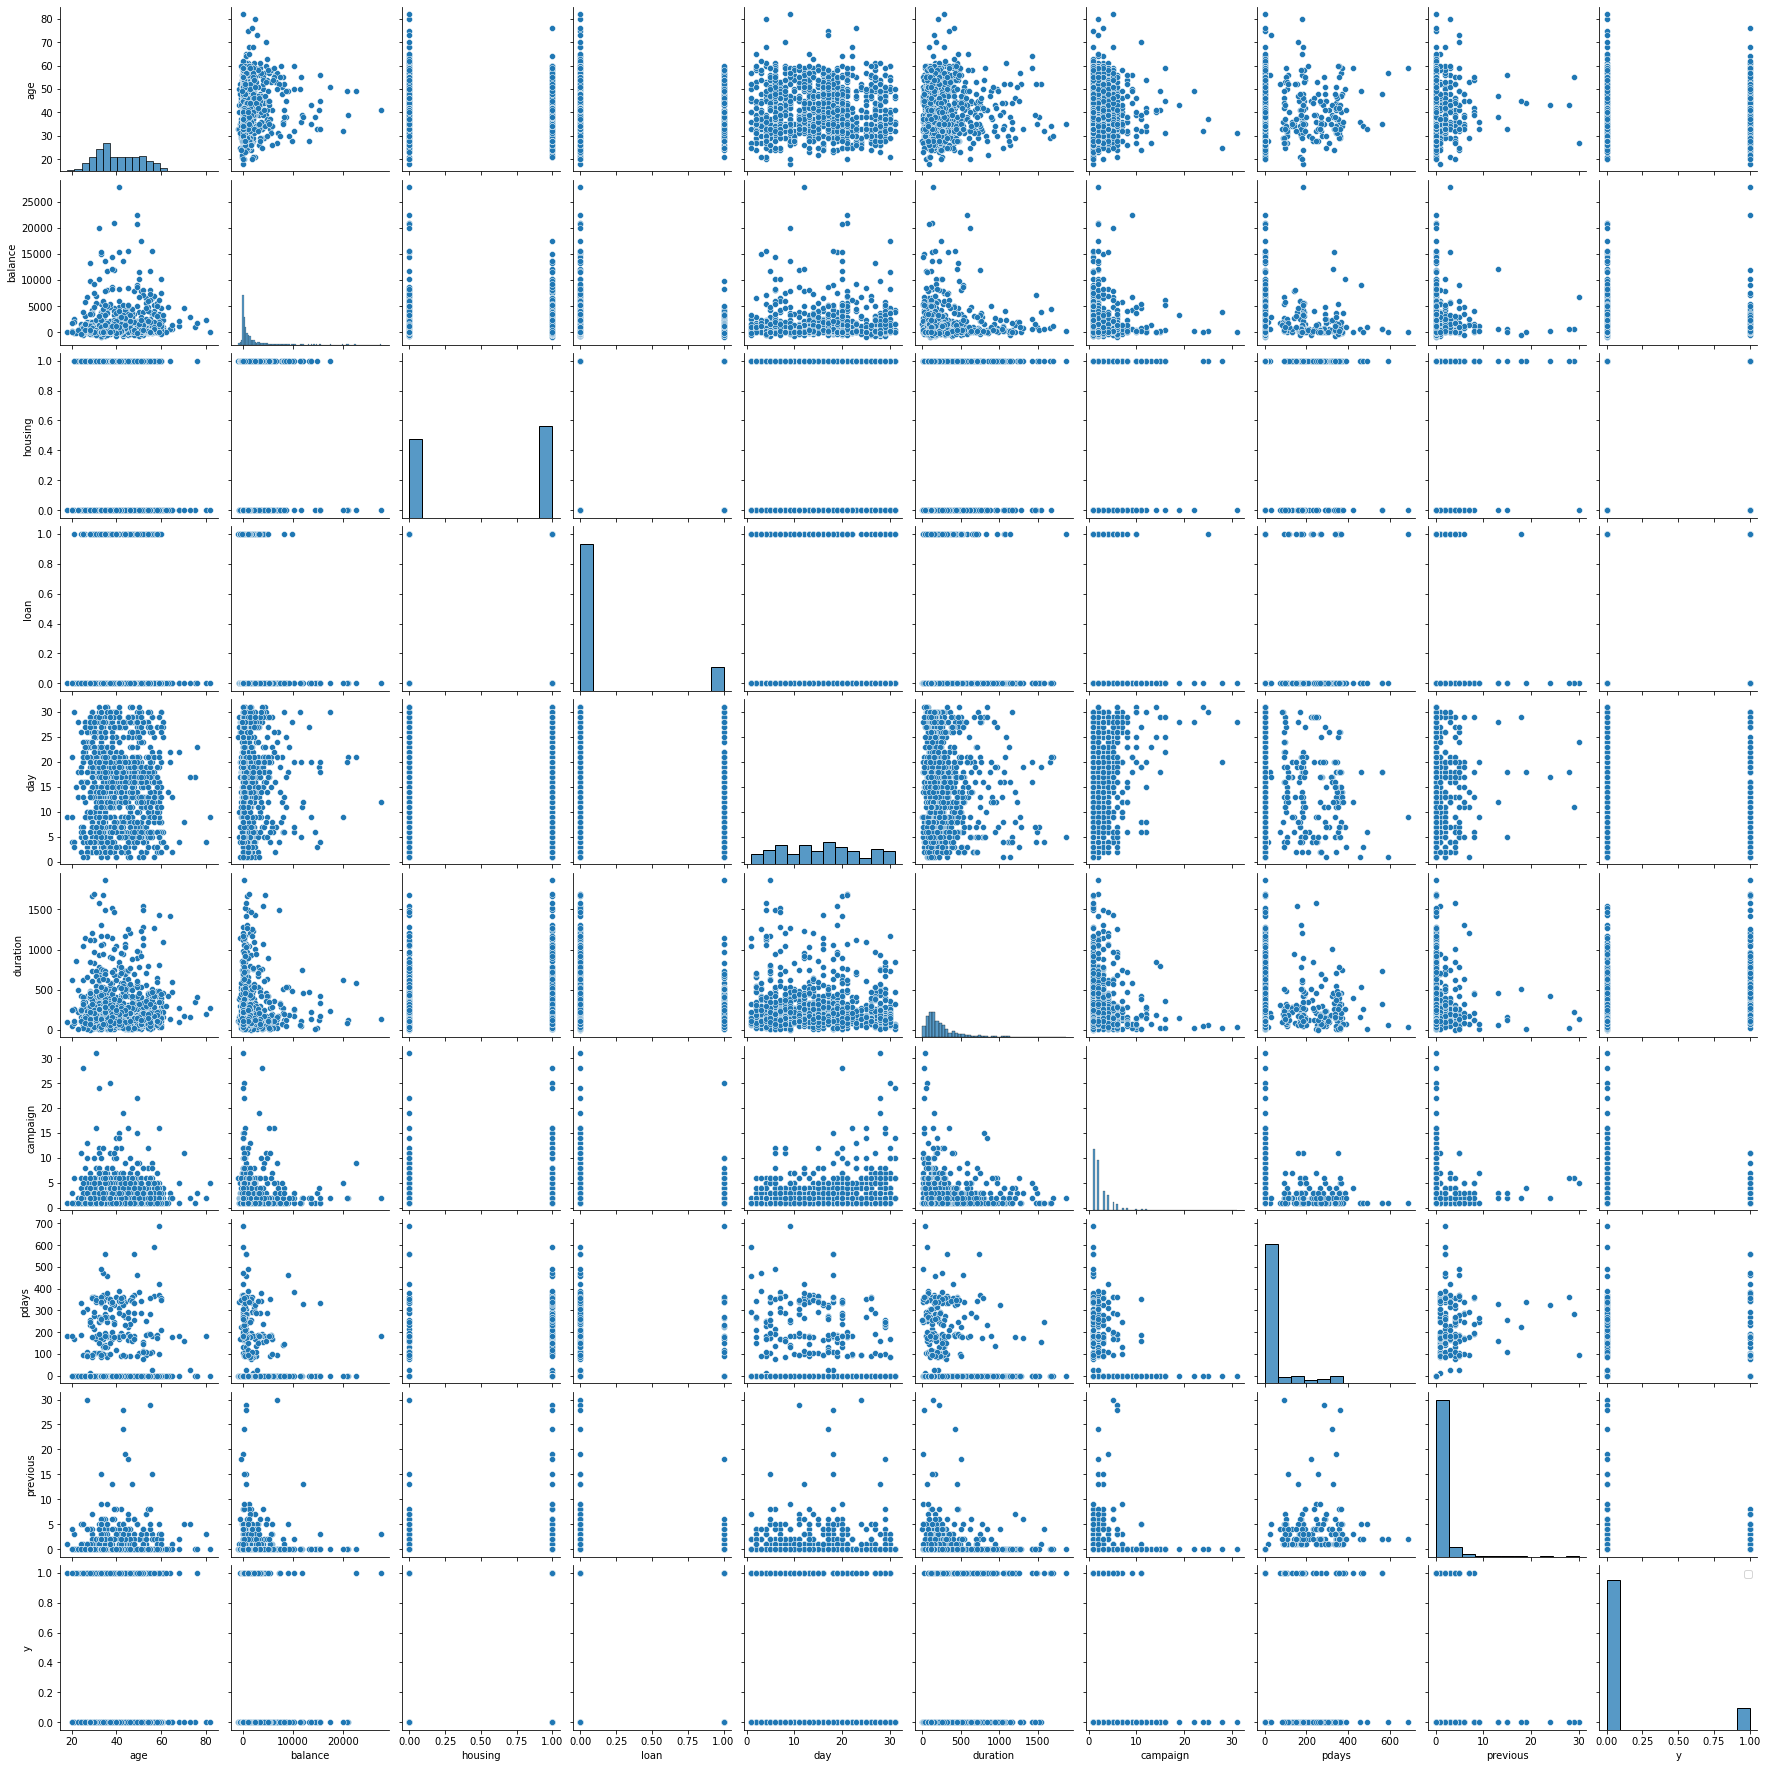

In [38]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
sns.pairplot(data.iloc[random_subset],  diag_kind='hist')
plt.legend()
pass

## Обработка пропущенных значений

Выведем статистику по пропущенным значениям для каждого признака:

In [39]:
data.isna().sum()

age              0
job            288
marital          0
education     1857
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

Исключим признак **poutcome** из датасета по причине подавляющего количества пропущенных значений:

In [40]:
data = data.drop(["poutcome"], axis = 1)
data.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,2143,True,False,NaN,5,may,261,1,-1,0,False
1,44,technician,single,secondary,29,True,False,NaN,5,may,151,1,-1,0,False
2,33,entrepreneur,married,secondary,2,True,True,NaN,5,may,76,1,-1,0,False
3,47,blue-collar,married,NaN,1506,True,False,NaN,5,may,92,1,-1,0,False
4,33,NaN,single,NaN,1,False,False,NaN,5,may,198,1,-1,0,False


Заполним оставшиеся пропущенные значения модой:

In [41]:
data["job"].fillna(data["job"].mode().iloc[0], inplace = True)
data["education"].fillna(data["education"].mode().iloc[0], inplace = True)
data["contact"].fillna(data["contact"].mode().iloc[0], inplace = True)

## Обработка категориальных значений

Для обработки категориальных признаков **job**, **marital**, **education**, **month** будем использовать бинаризацию:

In [42]:
categorial_table = pd.concat((pd.get_dummies(data['job']), pd.get_dummies(data['marital']), pd.get_dummies(data['month'])), axis = 1)
categorial_table.head()

,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Обработка бинарных значений

Бинарные признаки **housing**, **loan**, **y** заменим на числовые:

In [43]:
data['housing'] = pd.factorize(data['housing'])[0]
data['loan'] = pd.factorize(data['loan'])[0]
data['y'] = pd.factorize(data['y'])[0]

bin_table=pd.concat((data['housing'], data['loan'], data['y']), axis = 1)
bin_table.head()

,housing,loan,y
0,0,0,0
1,0,0,0
2,0,1,0
3,0,0,0
4,1,0,0


## Нормализация количественных признаков

Стандартизуем количественные признаки:

In [44]:
data_num_stand = (data[numerical_columns] - data[numerical_columns].mean(axis = 0)) / data[numerical_columns].std(axis = 0)
data_num_stand.head()

,age,balance,day,duration,campaign,pdays,previous
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,-0.411449,-0.251938
1,0.288526,-0.437890,-1.298462,-0.416122,-0.569344,-0.411449,-0.251938
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,-0.411449,-0.251938
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,-0.411449,-0.251938
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,-0.411449,-0.251938


In [45]:
data_num_stand.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04
mean,2.135579e-16,-4.067535e-16,-3.063960e-14,-5.313654e-17,1.723756e-14,1.057063e-13,-1.007183e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.159970e+00,-3.081114e+00,-1.779088e+00,-1.002467e+00,-5.693443e-01,-4.114486e-01,-2.519376e-01
25%,-7.473762e-01,-4.237673e-01,-9.379923e-01,-6.025100e-01,-5.693443e-01,-4.114486e-01,-2.519376e-01
50%,-1.823386e-01,-3.002766e-01,2.326005e-02,-3.035132e-01,-2.465576e-01,-4.114486e-01,-2.519376e-01
75%,6.652178e-01,2.158719e-02,6.240428e-01,2.362344e-01,7.622910e-02,-4.114486e-01,-2.519376e-01
max,5.091346e+00,3.309441e+01,1.825608e+00,1.809450e+01,1.944343e+01,8.297339e+00,1.191347e+02


## Формирование выборок

Объединим обработанные данные в одну таблицу:

In [46]:
data_stand = pd.concat((data_num_stand, bin_table, categorial_table), axis = 1)
data_stand.head()

,age,balance,day,duration,campaign,pdays,previous,housing,loan,y,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.288526,-0.437890,-1.298462,-0.416122,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,-0.411449,-0.251938,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,-0.411449,-0.251938,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Поскольку ранее было принято решение избавиться от признака, характеризующего успех предыдущих маркетинговых кампаний, удалим из итоговой таблицы признаки **pdays** и **previous**.

In [47]:
y = data_stand['y']
X = data_stand.drop(['pdays', 'previous','y'], axis = 1)
X.head()

,age,balance,day,duration,campaign,housing,loan,admin.,blue-collar,entrepreneur,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.288526,-0.437890,-1.298462,-0.416122,-0.569344,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Данные для обучения и тестирования разобьем в соотношении 4:1.

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

36168 9043


## Классификатор K ближайших соседей

Соберем результаты алгоритма в зависимости от количества соседей:

In [49]:
arr_train_e = []
arr_test_e = []
x_ax = []
err_test = 0
err_train = 0
for k in range(1, 60, 10):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    arr_test_e.append(1 - knn.score(X_test, y_test))
    arr_train_e.append(1- knn.score(X_train, y_train))
    x_ax.append(k)

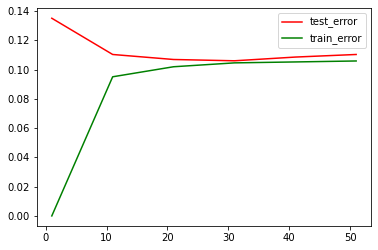

In [50]:
plt.plot(x_ax,arr_test_e, color='red')
plt.plot(x_ax,arr_train_e, color='green')
plt.legend(['test_error','train_error'])
pass

Наилучшим оказалось значение k = 21. Ошибка при данном значении параметра составляет 10.52%  
При меньшем значении параметра модель переобучается на тестовых данных, что выражается в большом разрыве между значениями метрик на тестовой и обучающей выборках.  
Дальнейшее увеличение параметра не даёт прироста качества модели.

Далее рассмотрим несколько других классификаторов

## SVC


In [51]:
from sklearn.svm import SVC

svc = SVC(gamma = 'auto')
svc.fit(X_train, y_train)

y_train_predict = svc.predict(X_train)
y_test_predict  = svc.predict(X_test)

error_train = np.mean(y_train != svc.predict(X_train))
error_test  = np.mean(y_test  != svc.predict(X_test))

print('Error train =', error_train)
print('Error test =', error_test)

Error train = 0.10935080734350808
Error test = 0.11257326108592282


## Random Forest

In [55]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

y_train_predict = rf.predict(X_train)
y_test_predict  = rf.predict(X_test)

error_train = np.mean(y_train != rf.predict(X_train))
error_test  = np.mean(y_test  != rf.predict(X_test))

print('Error train =', error_train)
print('Error test =', error_test)

Error train = 2.7648750276487504e-05
Error test = 0.10361605661837886


## Gradient Boosting Trees

In [56]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 25)
gbt.fit(X_train, y_train)

y_train_predict = gbt.predict(X_train)
y_test_predict  = gbt.predict(X_test)

error_train = np.mean(y_train != gbt.predict(X_train))
error_test  = np.mean(y_test  != gbt.predict(X_test))

print('Error train =', error_train)
print('Error test =', error_test)

Error train = 0.10846604733466048
Error test = 0.10870286409377419


## Обработка несбалансированных классов

In [2]:
from imblearn.under_sampling import RandomUnderSampler


## Выводы

В данной работе была проделана работа по визуализации и интерпретации используемого датасета, были обработаны пропущенные значения, бинарные и категориальные признаки. Также была произведена нормализация количественных признаков.  
Обработанные данные были разделены на тестовую и обучающую выборки, которые использовались в для обучения классификаторов.

Классификатор K ближайших соседей был обучен при разном значении параметра k, после чего было выбрано наиболее оптимальное с точки зрения ошибки на тестовой выборке значение параметра. При k = 21 удалось достичь ошибки в 10.52%

Также были проделаны эксперименты с MLP классификатором. Эксперементальным путем были подобраны параметр alpha, количество скрытых слоёв и количество нейронов в скрытом слое. Полученные данные были проанализированы на предмет выявления переобучения и недообучения при некоторых значениях параметров